In [19]:
import numpy as np
import scipy as sp
import statsmodels.formula.api as smf
import pylab as pl
import pandas as pd
import os
%pylab inline

import urllib3 as urllib
import urllib.request
import geopandas as gp
import choroplethNYC as cp
import requests
import io
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from fiona.crs import from_epsg

Populating the interactive namespace from numpy and matplotlib


In [4]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

In [5]:
!curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD > energy.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  3162k      0 --:--:--  0:00:01 --:--:-- 3162k      0 --:--:-- --:--:-- --:--:-- 2201k


In [6]:
!mv energy.csv $PUIDATA

In [9]:
energy = pd.read_csv('%s/energy.csv'%os.getenv("PUIDATA"))

In [11]:
energy.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'

In [16]:
urllib.request.urlretrieve(url, "manpluto.zip")

('manpluto.zip', <http.client.HTTPMessage at 0x1a235ed748>)

In [17]:
!unzip manpluto.zip -d $PUIDATA

Archive:  manpluto.zip
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/PLUTODD18v1.pdf  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.dbf  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.prj  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.sbn  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.sbx  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.shp  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.shp.xml  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/MN_Dcp_Mappinglot.shx  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/mn_pluto.dbf  
  inflating: /Users/anaemendezmendez/Docume

In [18]:
!mv manpluto.zip $PUIDATA

In [20]:
building_size = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

In [22]:
building_size.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,18V1,0,2867.154705,260.428942,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,18V1,7,10907.639931,417.764545,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,18V1,0,2665.033424,256.893308,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,0.000000e+00,None,1,None,None,18V1,0,15302.920914,505.033271,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,0.000000e+00,None,1,None,None,18V1,0,4374.612456,295.652483,"POLYGON ((992273.6849975586 224863.4904174805,..."


/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


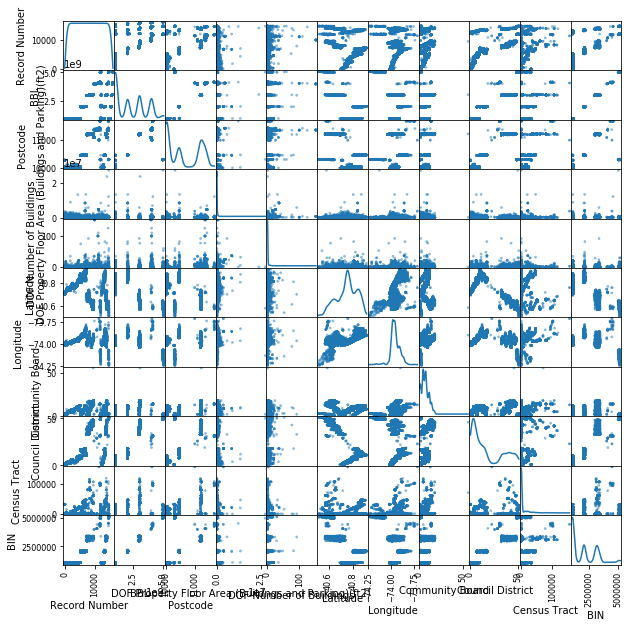

In [23]:
sfig = pd.scatter_matrix(energy, s=30, figsize=(10, 10), diagonal='kde')